# Predicting Poverty Around the World 

In this challenge, Goal is to predict the probability that individuals across seven different countries live below the poverty line at the $2.50/day threshold, given more than 50 demographic, economic, education, employment features. The probability of being in poverty was calculated using the Poverty Probability Index (PPI), which estimates an individual's poverty status using 10 questions about a household’s characteristics and asset ownership. The remaining data comes from the Financial Inclusion Insights household surveys conducted by InterMedia.

## Part 1 Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import learning_curve, GridSearchCV, cross_validate, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats, optimize, interpolate
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from xgboost import XGBRegressor
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train_data = pd.read_csv('train_values_wJZrCmI.csv', index_col='row_id',na_values=[''])
train_label = pd.read_csv('train_labels.csv',index_col='row_id',na_values=[''])
test_data = pd.read_csv('test_values.csv',index_col='row_id',na_values=[''])
combined_data = pd.concat([train_data,test_data])

In [3]:
#convert bool into int

bool_vas = ['is_urban','female','married','literacy','can_add','can_divide','can_calc_percents','can_calc_compounding','employed_last_year',
           'income_ag_livestock_last_year','income_friends_family_last_year','income_government_last_year','income_own_business_last_year',
            'income_private_sector_last_year','income_public_sector_last_year','formal_savings','informal_savings','cash_property_savings',
            'has_insurance','has_investment','borrowed_for_emergency_last_year','borrowed_for_daily_expenses_last_year','borrowed_for_home_or_biz_last_year',
            'can_call','can_text','can_use_internet','can_make_transaction','advanced_phone_use','reg_bank_acct','reg_mm_acct','reg_formal_nbfi_account',
            'financially_included','active_bank_user','active_mm_user','active_formal_nbfi_user','active_informal_nbfi_user','nonreg_active_mm_user']
for i in bool_vas:
    combined_data[i]=combined_data[i].astype('int')

In [4]:
pd.set_option('display.max_columns', None)
combined_data.head(5)

,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,employment_category_last_year,employment_type_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,C,0,18.0,1,1,P,Other,1.0,1,1,1,1,1,0,housewife_or_student,not_working,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1
1,C,1,30.0,1,1,P,Other,1.0,1,1,1,0,0,0,housewife_or_student,not_working,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,1,1,0,0,0,2,0,1,0,0,1,1,0,0,0,0,1,0,0
2,A,0,20.0,1,1,Q,Spouse,1.0,1,1,1,1,0,1,employed,irregular_seasonal,1.0,0,0,0,0,0,0,1,2,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A,0,61.0,0,1,Q,Head,0.0,0,1,1,0,1,1,employed,self_employed,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,D,0,26.0,1,1,X,Spouse,1.0,1,0,1,0,0,0,housewife_or_student,not_working,2.0,0,1,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3


In [5]:
print("Summary Statistics for 'poverty_probability': \n{}".format(train_label.poverty_probability.describe()))
print('Skewness is',train_label.poverty_probability.skew())

Summary Statistics for 'poverty_probability': 
count    12600.000000
mean         0.611272
std          0.291476
min          0.000000
25%          0.394000
50%          0.633000
75%          0.879000
max          1.000000
Name: poverty_probability, dtype: float64
Skewness is -0.45382563178375884


Text(0, 0.5, 'Frequency')

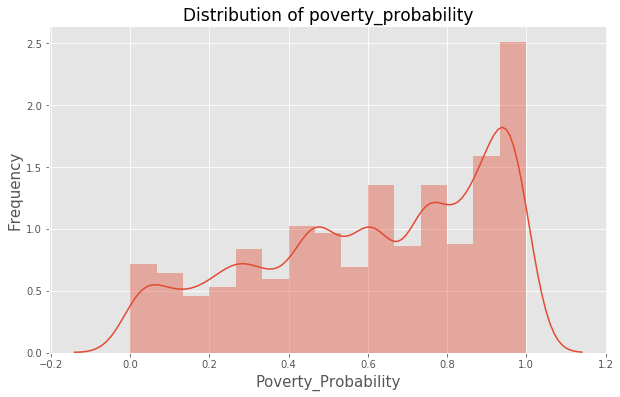

In [6]:
plt.figure(figsize=(10,6))
sns.distplot(train_label.poverty_probability, bins=15)
plt.title('Distribution of poverty_probability', size=17)
plt.xlabel('Poverty_Probability', size=15)
plt.ylabel('Frequency', size=15)

In [13]:
print("Summary Statistics for 'age': \n{}".format(train_data.age.describe()))

Summary Statistics for 'age': 
count    12600.000000
mean        36.280714
std         15.145945
min         15.000000
25%         25.000000
50%         33.000000
75%         45.000000
max        115.000000
Name: age, dtype: float64


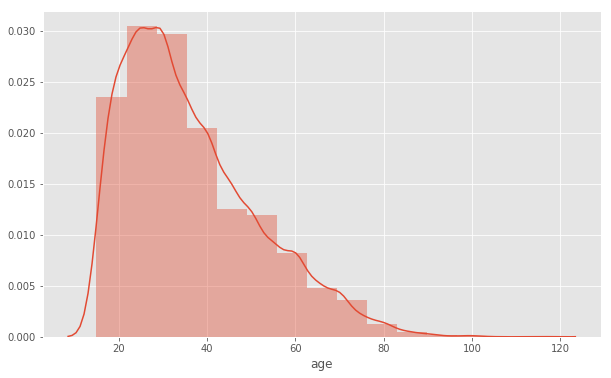

In [7]:
plt.figure(figsize=(10,6))
sns.distplot(combined_data.age, bins=15)
#plt.title('Distribution of poverty_probability', size=17)
#plt.xlabel('Poverty_Probability', size=15)
#plt.ylabel('Frequency', size=15)

In [6]:
scaler = preprocessing.StandardScaler()
combined_data['age_scaled'] = scaler.fit_transform(combined_data['age'].values.reshape(-1, 1))
combined_data['age_scaled'].head()
combined_data=combined_data.drop('age',axis=1)

In [7]:
#dummy conversion
category_vas = ['country','religion','relationship_to_hh_head','employment_category_last_year','employment_type_last_year']
combined_data_new = combined_data
for i in category_vas:
    print (combined_data_new[i].unique())
    combined_data_new = pd.concat([combined_data_new, pd.get_dummies(combined_data_new[i])], axis=1)
print(combined_data.shape)
print(combined_data_new.shape)
combined_data_new = combined_data_new.drop(category_vas,axis=1)
print(combined_data_new.shape)

['C' 'A' 'D' 'G' 'F' 'I' 'J']
['P' 'Q' 'X' 'O' 'N']
['Other' 'Spouse' 'Head' 'Son/Daughter' 'Sister/Brother' 'Father/Mother'
 'Unknown']
['housewife_or_student' 'employed' 'other' 'unemployed'
 'retired_or_disabled']
['not_working' 'irregular_seasonal' 'self_employed' 'salaried' 'other']
(21000, 58)
(21000, 87)
(21000, 82)


In [9]:
combined_data_new.head()

,is_urban,female,married,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,bank_interest_rate,mm_interest_rate,mfi_interest_rate,other_fsp_interest_rate,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,age_scaled,A,C,D,F,G,I,J,N,O,P,Q,X,Father/Mother,Head,Other,Sister/Brother,Son/Daughter,Spouse,Unknown,employed,housewife_or_student,other,retired_or_disabled,unemployed,irregular_seasonal,not_working,other,salaried,self_employed
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1.0,1,1,1,1,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,-1.207578,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,1,1,1.0,1,1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,1,1,0,0,0,2,0,1,0,0,1,1,0,0,0,0,1,0,0,-0.418702,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,1,1,1.0,1,1,1,1,0,1,1.0,0,0,0,0,0,0,1,2,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.076098,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0.0,0,1,1,0,1,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.619227,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,1,1.0,1,0,1,0,0,0,2.0,0,1,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,0,0.0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,-0.681660,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [9]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
category_vas = ['country','religion','relationship_to_hh_head','employment_category_last_year','employment_type_last_year']
country_labels = le.fit_transform(combined_data['country'])
combined_data['Country_Label'] = country_labels
religion_labels = le.fit_transform(combined_data['religion'])
combined_data['Religion_Label'] = religion_labels
relation_labels = le.fit_transform(combined_data['relationship_to_hh_head'])
combined_data['Relation_Label'] = relation_labels
employment_category_labels = le.fit_transform(combined_data['employment_category_last_year'])
combined_data['Employment_category_labels'] = employment_category_labels
employment_type_labels = le.fit_transform(combined_data['employment_type_last_year'])
combined_data['Employment_type_last_year_labels'] = employment_type_labels
combined_data = combined_data.drop(category_vas,axis=1)

In [8]:
#missing
print(combined_data_new.shape)
num_missing = combined_data_new.shape[0]-combined_data_new.count()
#print(num_missing)
#delete bank_interest_rate,mm_interest_rate,mfi_interest_rate, other_fsp_interest_rate, too many missing values
combined_data_new = combined_data_new.drop(['bank_interest_rate','mm_interest_rate','mfi_interest_rate','other_fsp_interest_rate'],axis=1)
#fill education_level and employment_last_year with mode
combined_data_new.fillna(combined_data['education_level'].mode()[0],inplace=True)
combined_data_new.fillna(combined_data['share_hh_income_provided'].mode()[0],inplace=True)
print(np.count_nonzero(combined_data_new.isnull()))

(21000, 82)
0


In [9]:
#change 3 duplicate 'other' tags
name_list=list(combined_data_new)
#63,70,75
name_list[63]='other_relationship'
name_list[70]='other_category'
name_list[75]='other_work'
combined_data_new.columns=name_list
combined_data_new.head(5)

,is_urban,female,married,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,age_scaled,A,C,D,F,G,I,J,N,O,P,Q,X,Father/Mother,Head,other_relationship,Sister/Brother,Son/Daughter,Spouse,Unknown,employed,housewife_or_student,other_category,retired_or_disabled,unemployed,irregular_seasonal,not_working,other_work,salaried,self_employed
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1.0,1,1,1,1,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,-1.207578,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,1,1,1.0,1,1,1,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,2,0,1,0,0,1,1,0,0,0,0,1,0,0,-0.418702,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,1,1,1.0,1,1,1,1,0,1,1.0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.076098,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0,0,1,0.0,0,1,1,0,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.619227,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,1,1.0,1,0,1,0,0,0,2.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,-0.681660,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [10]:
train_dt = combined_data_new[0:12600]
test_dt = combined_data_new[12600:]
print(train_dt.shape)
print(test_dt.shape)

(12600, 78)
(8400, 78)


In [11]:
merged_data = train_dt.merge(train_label,left_on='row_id',right_on='row_id')
#merged_data = merged_data.drop('row_id',axis=1)
print(merged_data.shape)
merged_data.head(5)

(12600, 79)


,is_urban,female,married,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,employed_last_year,share_hh_income_provided,income_ag_livestock_last_year,income_friends_family_last_year,income_government_last_year,income_own_business_last_year,income_private_sector_last_year,income_public_sector_last_year,num_times_borrowed_last_year,borrowing_recency,formal_savings,informal_savings,cash_property_savings,has_insurance,has_investment,num_shocks_last_year,avg_shock_strength_last_year,borrowed_for_emergency_last_year,borrowed_for_daily_expenses_last_year,borrowed_for_home_or_biz_last_year,phone_technology,can_call,can_text,can_use_internet,can_make_transaction,phone_ownership,advanced_phone_use,reg_bank_acct,reg_mm_acct,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,age_scaled,A,C,D,F,G,I,J,N,O,P,Q,X,Father/Mother,Head,other_relationship,Sister/Brother,Son/Daughter,Spouse,Unknown,employed,housewife_or_student,other_category,retired_or_disabled,unemployed,irregular_seasonal,not_working,other_work,salaried,self_employed,poverty_probability
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1.0,1,1,1,1,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,-1.207578,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.515
1,1,1,1,1.0,1,1,1,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,2,0,1,0,0,1,1,0,0,0,0,1,0,0,-0.418702,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0.981
2,0,1,1,1.0,1,1,1,1,0,1,1.0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0.0,0,0,0,1,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.076098,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0.982
3,0,0,1,0.0,0,1,1,0,1,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.619227,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0.879
4,0,1,1,1.0,1,0,1,0,0,0,2.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,3,-0.681660,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0.796


{'whiskers': [<matplotlib.lines.Line2D at 0x1e3a3c0d780>,
 'caps': [<matplotlib.lines.Line2D at 0x1e3a3c0de10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e3a3c0d358>,
 'medians': [<matplotlib.lines.Line2D at 0x1e3a3c134e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e3a3c13828>,
 'means': []}

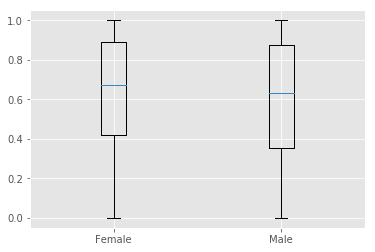

In [42]:
fig=plt.figure()
axes1=fig.add_subplot(1,1,1)
axes1.boxplot([merged_data[merged_data['female']==True]['poverty_probability'],
              merged_data[merged_data['female']==False]['poverty_probability']],
               labels=['Female','Male'])

In [12]:
print(merged_data.corr()['poverty_probability'].sort_values(ascending=False)[:10])
print(merged_data.corr()['poverty_probability'].sort_values(ascending=False)[-10:])

poverty_probability              1.000000
D                                0.235712
A                                0.196379
irregular_seasonal               0.140121
num_shocks_last_year             0.135472
avg_shock_strength_last_year     0.129479
income_ag_livestock_last_year    0.103013
married                          0.098294
Q                                0.093705
Spouse                           0.058340
Name: poverty_probability, dtype: float64
active_bank_user                     -0.245175
advanced_phone_use                   -0.247682
phone_ownership                      -0.252787
formal_savings                       -0.252813
num_financial_activities_last_year   -0.261385
can_text                             -0.261726
can_use_internet                     -0.284346
phone_technology                     -0.289282
is_urban                             -0.290159
education_level                      -0.345607
Name: poverty_probability, dtype: float64


In [13]:
c1 = merged_data.corr().abs().unstack()
print(c1.sort_values(ascending = False).drop_duplicates())
#There is not a strong and obvious relationship between age and probability of poverty, on average.
#high_c = ['reg_mm_acct','num_informal_institutions_last_year','num_times_borrowed_last_year','reg_formal_nbfi_account','reg_bank_acct','Employment_category_labels','num_formal_institutions_last_year','phone_technology','num_shocks_last_year']
#dt = merged_data.drop(high_c,axis=1)
#print(dt.shape)
#c2 = dt.corr().abs().unstack()
#print(c2.sort_values(ascending = False).drop_duplicates())

poverty_probability                  poverty_probability                      1.000000
reg_mm_acct                          active_mm_user                           0.896766
employed_last_year                   not_working                              0.894372
active_informal_nbfi_user            num_informal_institutions_last_year      0.869380
C                                    P                                        0.855994
housewife_or_student                 not_working                              0.853543
borrowing_recency                    num_times_borrowed_last_year             0.839256
active_formal_nbfi_user              reg_formal_nbfi_account                  0.826650
reg_bank_acct                        active_bank_user                         0.815159
num_financial_activities_last_year   num_formal_institutions_last_year        0.774544
employed                             housewife_or_student                     0.763385
phone_technology                     phone_

In [14]:
#backup
data_backup = merged_data
proverty_train_X = merged_data.drop('poverty_probability',axis=1)
proverty_train_Y = (merged_data['poverty_probability']*100).astype('int')
proverty_test_X = test_dt
print(proverty_train_X.shape)
print(proverty_test_X.shape)

(12600, 78)
(8400, 78)


## Training data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(proverty_train_X,proverty_train_Y, random_state=0, test_size=0.2)

In [60]:
# Build RF classifier to use in feature selection
clf = RandomForestRegressor(n_estimators=1000)

# Build step forward feature selection
sfs1 = sfs(clf,k_features=20,forward=True,floating=False,scoring='r2',cv=3)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

In [51]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 3, 5, 13, 15, 16, 33, 37, 38, 42, 44, 49, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 63, 64, 67, 70, 71, 72, 73, 75]


In [36]:
feature_to_pick = 30
feature_top_n, feature_importance = get_top_n_features(proverty_train_X, proverty_train_Y, feature_to_pick)
proverty_train_X = pd.DataFrame(proverty_train_X[feature_top_n])
proverty_test_X = pd.DataFrame(proverty_test_X[feature_top_n])

Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:0.13698412698412699
Top N Features RF Train Score:0.9995238095238095
Sample 10 Features from RF Classifier
0                            age_scaled
1          avg_shock_strength_last_year
2              share_hh_income_provided
3                  num_shocks_last_year
5    num_financial_activities_last_year
4                       education_level
6                      phone_technology
7          num_times_borrowed_last_year
8                  can_calc_compounding
9                     can_calc_percents
Name: feature, dtype: object
Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:0.10055555555555555
Top N Features Ada Train Score:0.10523809523809524
Sample 10 Feature from Ada Classifier:
30                                     G
4                        education_level
31                         has_insurance
6  

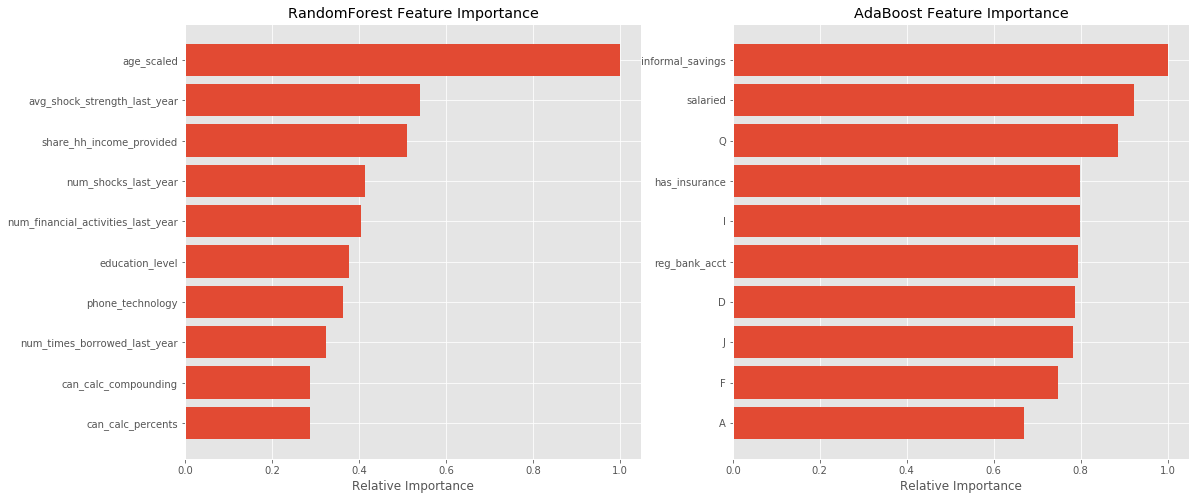

In [37]:
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[32:32+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

# Adapted from Gradient Boosting regression
pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize = (18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos, rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

In [44]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train, gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test, gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)

In [31]:
#Fitting RandomForest regressor

rfr_best = RandomForestRegressor()
#params = {'min_samples_split':range(10,100,1)}

#gs = GridSearchCV(estimator = rfr_best, params, cv=4)
#gs.fit(X_train,y_train)

#print(gs.best_score_)
#print(gs.best_params_)

param_test2 = {'min_samples_leaf':range(1,10,1),'min_samples_split':range(2,100,1)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 100,max_depth= 12,oob_score=True, random_state=10),
   param_grid = param_test2, cv=5)
gsearch2.fit(X_train,y_train)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'min_samples_leaf': 5, 'min_samples_split': 15}
0.4070637466380971


In [32]:
regr = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=10,max_depth= 12,min_samples_leaf=5,min_samples_split=15)
model=regr.fit(X_train, y_train)
model.score(X_test, y_test)

0.4073555856202301

In [59]:
gbm = XGBRegressor(n_estimators= 200, max_depth= 5,min_child_weight=1,gamma=1,learning_rate=0.1,oob_score=True)
model=gbm.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\Glenn\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[08:13:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.43212732911043983

In [37]:
final_model = gbm.fit(proverty_train_X,proverty_train_Y)
predictions = final_model.predict(proverty_test_X)

C:\Users\Glenn\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Glenn\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:01:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
Submission = pd.DataFrame({'poverty_probability': predictions/100})
print(Submission.head())
Submission.to_csv('submission_format.csv')

   poverty_probability
0             0.280387
1             0.542158
2             0.477389
3             0.256814
4             0.794256
